# Documentation

This module contains a group of key scripts in the subdirectory ***fmri_workflow/*** that run most of the workflow for a specific subject. These can be combined in the script ***fmri_workflow/SubjectLevel.py*** on a cluster. Before running this workflow, 3 preparatory steps are necessary:  
1. Preprocessing the fMRI data using FMRIPREP on the Hummel cluster (***adjuvant/hummel_fmriprep.sh***)  
2. Fitting the Glaze model (***adjuvant/stan_bids.py***)  
3. Registering the Glasser parcellation on each subject's specific cortical surface (***adjuvant/fcp_to_fsnative.py***)  
  
Then, the main workflow (or specific parts of the workflow) can be run individually per subject. The workflow comprises pupil pre-processing, extraction of behavioral data, extraction of subcortical ROI time series, construction of the general linear model and extraction of choice or switch epochs.

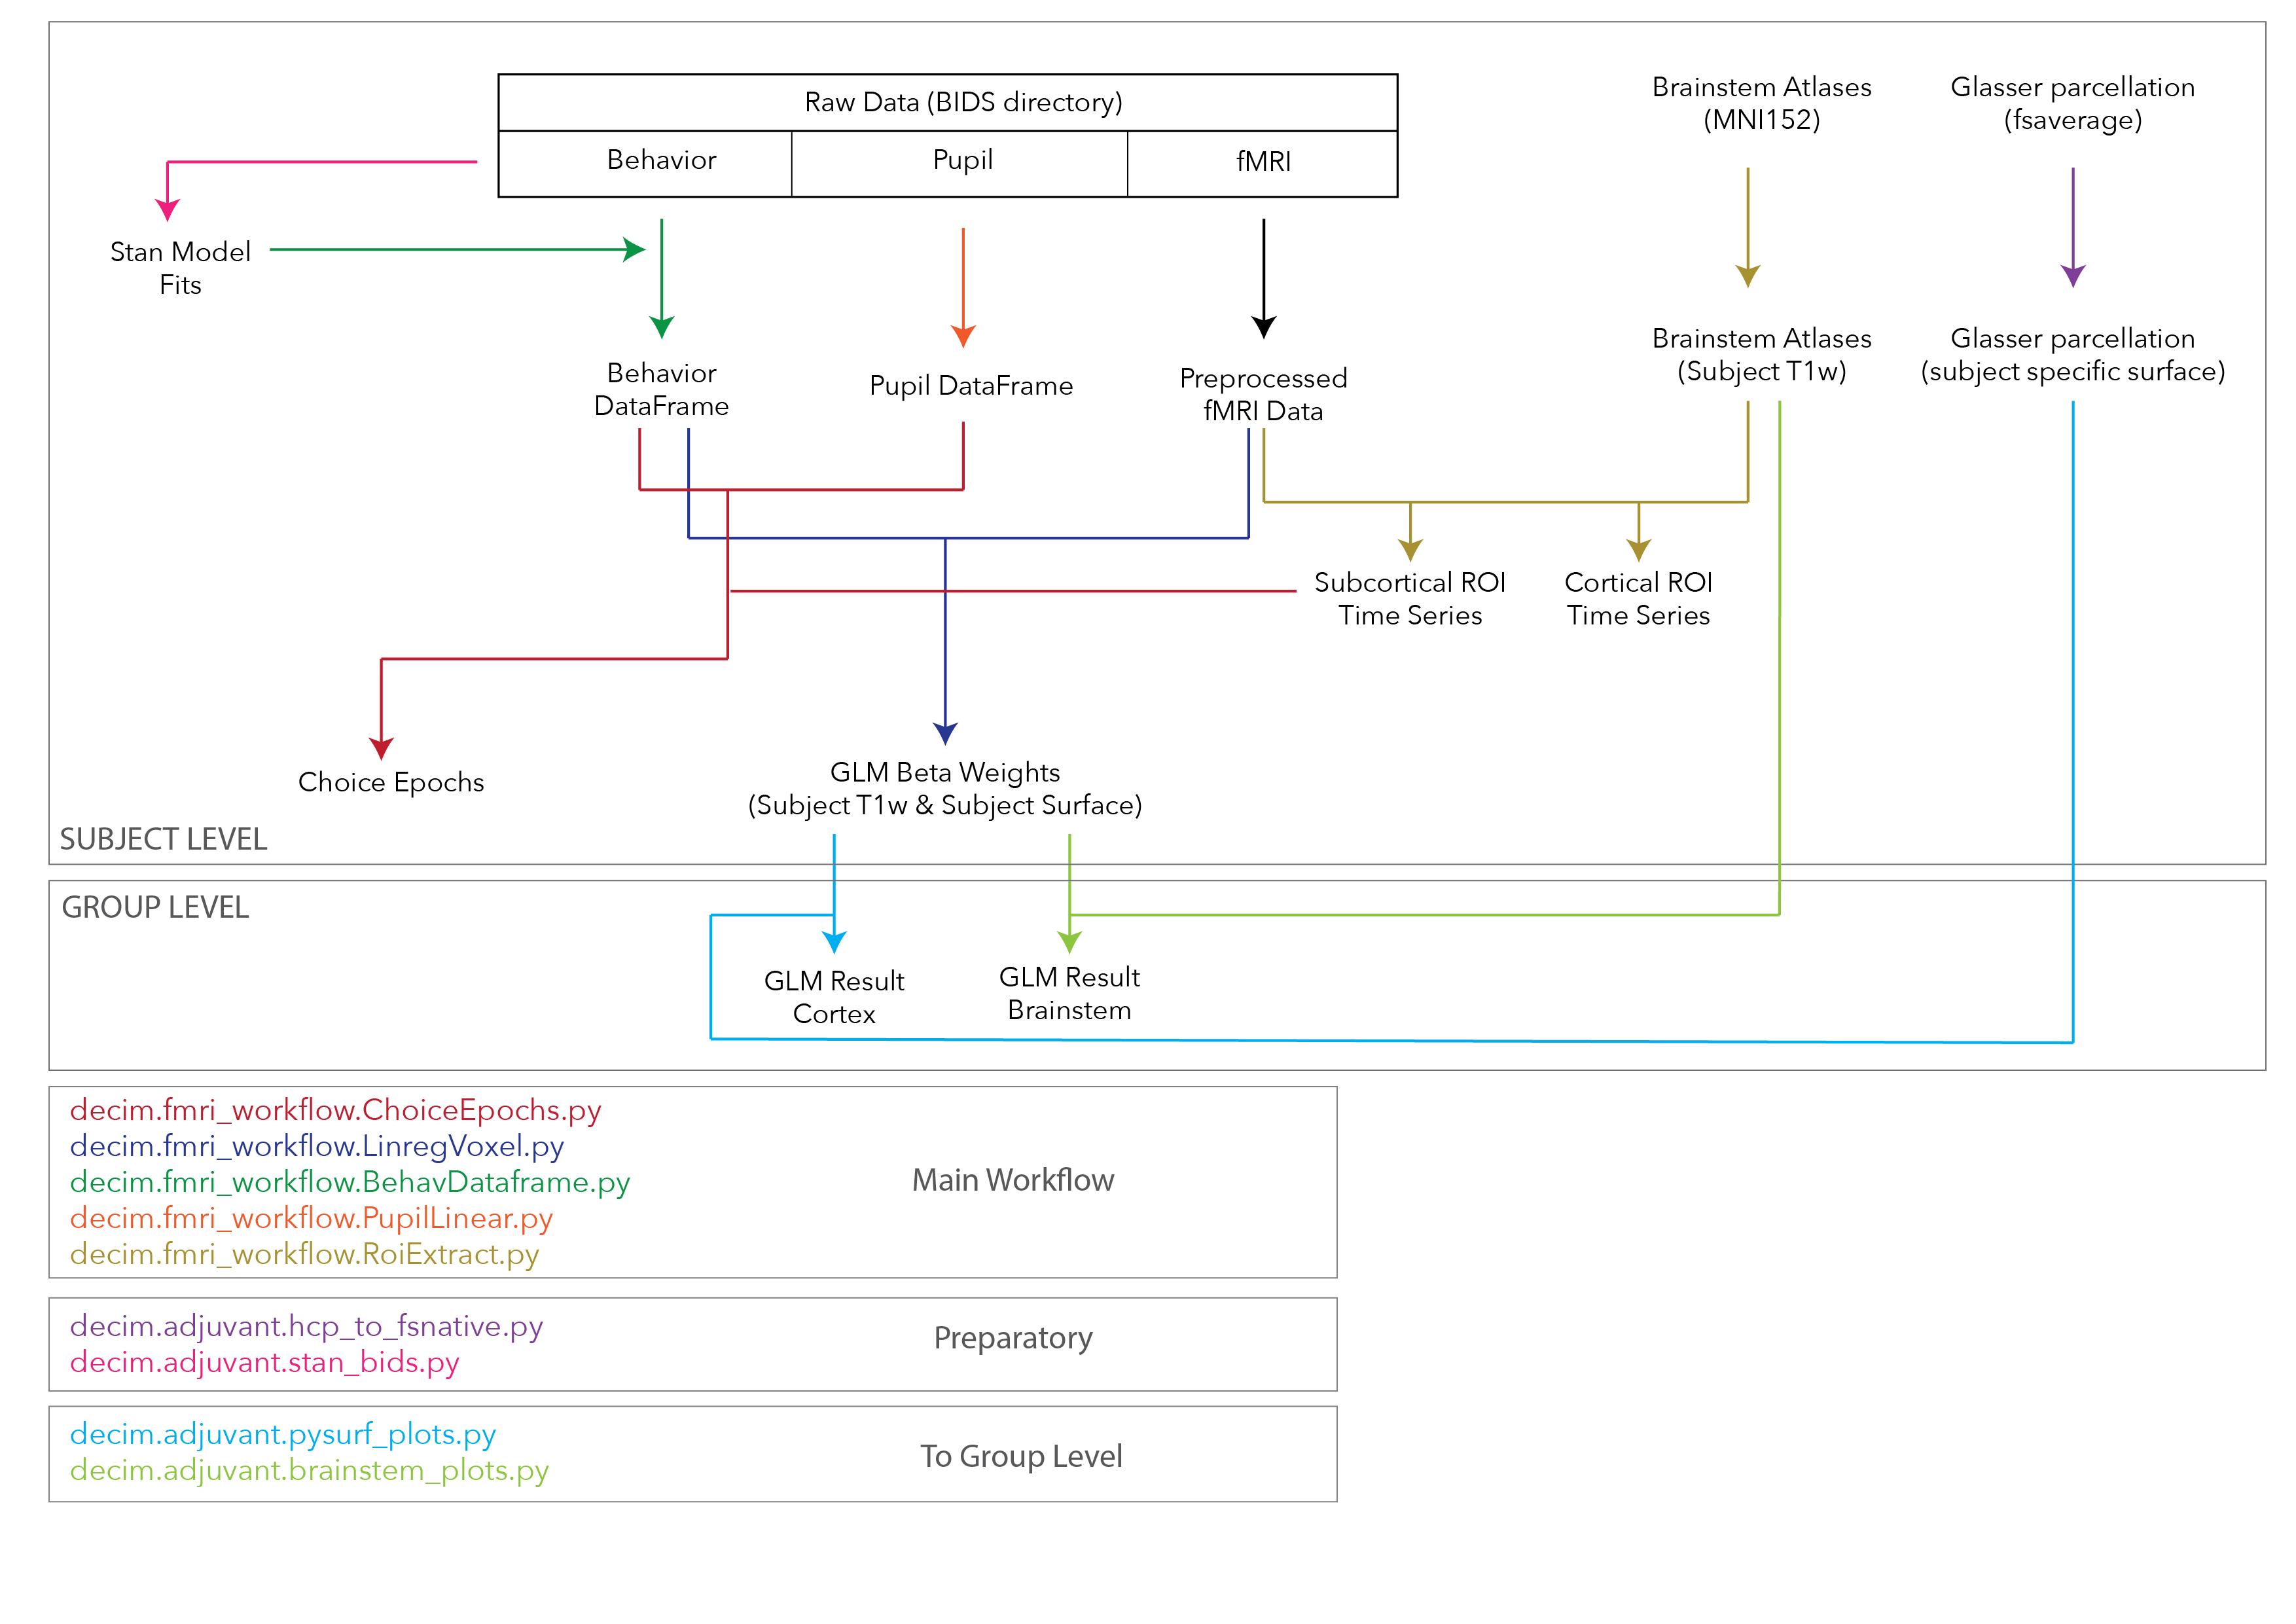

In [5]:
from IPython.display import Image
import pandas as pd
from os.path import join
Image("workflow.png")

### 0. File System
I try to stick to the following filing system:  

```
Flex_dir
├── raw
│   └── bids_mr_v1.2
├── pupil
│   └── linear_pupilframes_manual
│       └── pupilframe_{subject}_{session}_{run}.hdf
├── fMRI
│   ├── completed_preprocessed
│   │   └── {subject}
│   └── atlases
│       ├── original_atlases
│       └── {subject}
├── behavior
│   └── Stan_Fits_{datetime}
│       ├── {subject}_stanfit.hdf
│       └── summary_stan_fits.csv
└── Workflows
    └── {Description}_{datetime}
        ├── {subject}
        └── GroupLevel
```

### 1. Preparatory Steps

#### 1.1 Stan fits
Script ***adjuvant/stan_bids.py*** fits the Glaze model to all subjects and sessions individually on the **Hummel Cluster**. On the cluster open python and submit by running the following code:  

    from decim.adjuvant import stan_bids
    stan_bids.submit()
    
Alternatively, model can also be fitted for one subject and one session manually in any environment using the function ***fit_session*** and specifying the keyword arguments ***bids_mr*** and ***flex_dir***.

Than, the function ***concatenate*** should be used to generate one summary pd.DataFrame with all modes and confidence intervals of fitted parameter estimates of all subjuects. This summary dataframe will be used by other scripts later.

It should have the following format:

In [5]:
pd.read_csv('example_data/summary_stan_fits.csv', index_col=0).head()

,hlower,hmode,hupper,session,subject,vlower,vmode,vupper
0,0.008352,0.027712,0.061274,ses-1,sub-1,1.000038,1.000038,1.648083
1,0.005917,0.018201,0.039008,ses-2,sub-1,1.000073,1.000073,1.636907
2,0.000910,0.007208,0.022555,ses-3,sub-1,1.005034,1.377303,2.365726
3,0.001477,0.005217,0.017964,ses-1,sub-2,1.000280,1.342177,1.969049
4,0.004224,0.015083,0.034053,ses-2,sub-2,1.000079,1.022015,1.710843


#### 1.2 FMRIPREP
Run FMRIPREP for all subjects (currently on the **Hummel Cluster**). It is submitted with the bash script ***adjuvant/hummel_fmriprep.sh***. Within the script change the variables. This might take long... Validate results afterwards manually.

#### 1.3 Prepare Glasser parcellation
Then, after FMRIPREP is finished, download the Glasser atlas and register it to every subject's specific cortical surface (fsnative space). Script ***/adjuvant/hcp_to_fsnative.py***

### 2. Main Workflow
Generally, the main workflow comprises pupil pre-processing (***fmri_workflow/PupilLinear.py***), extraction of behavioral data (***fmri_workflow/BehavDataframe.py***), extraction of subcortical ROI time series (***fmri_workflow/RoiExtract.py***), construction of the general linear model (***fmri_workflow/LinregVoxel.py***) and extraction of choice or switch epochs (***fmri_workflow/ChjoiceEpochs.py*** and ***fmri_workflow/SwitchEpochs.py***). The scripts can be run either individually (within all scripts, the function ***execute*** runs the script per subject, session and run) or conveniently encapsulated by a specified workflow in ***fmri_workflow/SubjectLevel.py***. Examples of such workflow specifications (e.g. everything, just GLM, etc....) are listed within the script. The specified workflows can be easily submitted to different clusters by running the following lines of code within python:

    from decim.fmri_workflow import SubjectLevel
    SubjectLevel.submit('sub-17', 'Climag')
    
Within the submit function, specify the subject and the environment ('Climag', 'Hummel'). Jobs are then scheduled.

**CAVE**: The blink detection in the pupil pre-processing script should be done manually, and thus, should not be included in the workflow, which is submitted to the cluster. This can be done in a jupyter notebook (see below). As the manual pre-processing is quite time consuming, it should be done once in the beginning.

#### 2.1 Pupil Pre-processing
***fmri_workflow/PupilLinear.py***  
When manually preprocessing in an interactive environment, do the following consecutive steps:  
1. give start and end timepoints (in s, not ms) of pupil time series which has not been automatically been detected as polluted, but should be ('false negatives'). Terminate this, by typing '123' for both start and end.
2. Then, an identical dialogue opens (start-end). This time, inout start and end timepoints of 'false positives'. Terminate this phase by double typing '321'.  
3. Validate the new result and approve by typing 'yes'. Otherwise ('no'), repeat 1 and 2

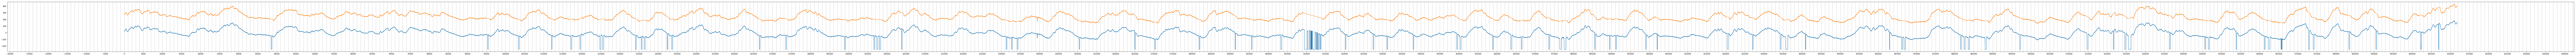

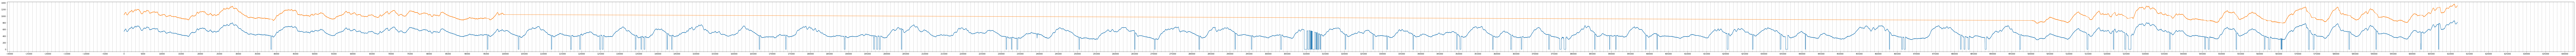

,pa_right,time,gx_right,gy_right,saccade,blink,message,message_value,trial_id,interpol,man_deblink,bp_interpol,biz
0,541.0,2392993.0,964.299988,531.200012,False,False,NaN,NaN,NaN,541.0,541.0,-12.915111,-0.215952
1,541.0,2392994.0,964.000000,529.799988,False,False,NaN,NaN,NaN,541.0,541.0,-12.833944,-0.214634
2,541.0,2392995.0,963.400024,528.500000,False,False,NaN,NaN,NaN,541.0,541.0,-12.751038,-0.213287
3,541.0,2392996.0,962.400024,527.799988,False,False,NaN,NaN,NaN,541.0,541.0,-12.666404,-0.211913
4,541.0,2392997.0,961.799988,528.799988,False,False,NaN,NaN,NaN,541.0,541.0,-12.580054,-0.210510
5,542.0,2392998.0,961.500000,529.799988,False,False,NaN,NaN,NaN,542.0,542.0,-12.492001,-0.209080
6,542.0,2392999.0,961.900024,530.900024,False,False,NaN,NaN,NaN,542.0,542.0,-12.402261,-0.207623
7,543.0,2393000.0,962.599976,530.299988,False,False,NaN,NaN,NaN,543.0,543.0,-12.310850,-0.206138
8,543.0,2393001.0,962.900024,529.599976,False,False,NaN,NaN,NaN,543.0,543.0,-12.217784,-0.204627
9,542.0,2393002.0,963.099976,528.599976,False,False,NaN,NaN,NaN,542.0,542.0,-12.123082,-0.203089


In [1]:
from decim.fmri_workflow import PupilLinear as pf
pf.execute('sub-17', 'ses-2', 'inference_run-5', '/Volumes/flxrl/FLEXRULE/', manual=True) #set manual to True

#### 2.2 Extraction of Behavior
**fmri_workflow/BehavDataframe.py***  
Draws on the fitted subjective Glaze hazard rates. Ouputs a pd.DataFrame with rowas representing events (sample, choice grating, response) and different continuous and categorical columns. One .hdf file per session, different runs as keys within hdf-file. Example:

In [8]:
pd.read_hdf('example_data/BehavFrame_sub-17_ses-2.hdf', key='inference_run-4').head()

,onset,event,value,belief,obj_belief,gen_side,stim_id,rule_resp,trial_id,reward,...,point,response,response_left,response_right,stimulus_horiz,stimulus_vert,stimulus,rresp_left,rresp_right,belief_left
0,8.800310,GL_TRIAL_LOCATION,1.82456418012,1.824564,1.824564,0.5,NaN,NaN,1.0,NaN,...,True,False,False,False,False,False,False,False,False,-1.824564
1,9.308633,GL_TRIAL_LOCATION,-0.111524653533,1.698556,1.629328,0.5,NaN,NaN,2.0,NaN,...,True,False,False,False,False,False,False,False,False,-1.698556
2,9.713305,GL_TRIAL_LOCATION,0.589371035236,2.275245,2.150222,0.5,NaN,NaN,3.0,NaN,...,True,False,False,False,False,False,False,False,False,-2.275245
3,10.099345,GL_TRIAL_LOCATION,-0.173242741519,2.079006,1.861375,0.5,NaN,NaN,4.0,NaN,...,True,False,False,False,False,False,False,False,False,-2.079006
4,10.499641,GL_TRIAL_LOCATION,0.802225903108,2.862392,2.576719,0.5,NaN,NaN,5.0,NaN,...,True,False,False,False,False,False,False,False,False,-2.862392


#### 2.3 ROI Time Series Extraction
***fmri_workflow/RoiExtract.py***  
Extracts time series in subcortical ROIS and in cortical Glasser labels. Outputs two analog pd.DataFrames for the cortical and the subcortical data with scanning time points as rows and regions as columns.

In [10]:
pd.read_hdf('example_data/BrainstemRois_sub-17_ses-2.hdf', key='inference_run-5').head()

,4th_ventricle,NAc,SNc,VTA,aan_dr,keren_lc_1std,keren_lc_2std,zaborsky_bf123,zaborsky_bf4
0,0.587415,0.116316,-0.206505,-0.063276,-0.056804,0.275559,0.202302,0.263408,0.051610
1,0.180813,-0.039057,0.029820,-0.262680,-0.157962,-0.040595,-0.047893,0.106733,0.130984
2,-0.279223,-0.035829,-0.081389,-0.091962,0.191005,0.393137,0.343662,0.105277,0.102569
3,0.233628,0.214593,0.008941,-0.360550,-0.544182,-0.124183,-0.141517,0.036388,0.201825
4,0.843819,0.430051,-0.082368,0.114611,-0.379786,0.296557,0.271582,0.103921,0.110858


In [11]:
pd.read_hdf('example_data/CortRois_sub-17_ses-2.hdf', key='inference_run-5').head()

,L_???,L_V1_ROI,L_MST_ROI,L_V6_ROI,L_V2_ROI,L_V3_ROI,L_V4_ROI,L_V8_ROI,L_4_ROI,L_3b_ROI,...,R_p47r_ROI,R_TGv_ROI,R_MBelt_ROI,R_LBelt_ROI,R_A4_ROI,R_STSva_ROI,R_TE1m_ROI,R_PI_ROI,R_a32pr_ROI,R_p24_ROI
0,0.343634,0.292293,0.809745,0.517128,0.215138,0.453662,0.237143,0.854736,0.522073,0.609582,...,0.322533,-0.039519,1.203091,1.269812,1.157165,0.066813,0.683141,0.594020,0.301195,0.652959
1,0.303550,0.426137,0.615833,0.358032,0.245610,0.499310,0.247741,0.669776,0.533816,0.284310,...,-0.051025,-0.317333,0.764449,0.542017,0.692863,0.051631,0.523544,0.719822,0.448580,0.702820
2,0.180007,0.162680,0.621912,-0.446200,0.162090,0.330016,0.206404,0.769654,0.557005,-0.089236,...,0.292833,0.254769,0.479367,0.273978,0.154577,0.112268,0.276635,0.154211,0.504486,0.431937
3,0.055111,-0.077228,0.473704,-0.119351,-0.045861,0.259577,0.103465,0.781271,0.371894,-0.421734,...,0.405369,0.112072,0.246709,0.392692,0.230513,0.077664,0.098625,0.053149,0.097401,0.027440
4,0.161660,0.514551,1.082769,1.075772,0.541033,0.849963,0.652387,1.271017,0.436535,0.311383,...,1.154112,-0.224698,0.563738,0.426489,0.632558,0.430253,0.357170,0.187682,0.368147,-0.010519


#### 2.4 General Linear Model
***fmri_workflow/LinregVoxel.py***  
Needs Behavior DataFrame and preprocessed fMRI data. Predicts voxels with behavioral regressors. Running LinregVoxel gives three outputs: i) the resulting beta-weights as a nifti (not shown here), ii) the resulting beta-weights on the cortical surface and iii) the input design matrix for later diagnostics, etc.


***beta-weights on the surface*** are stored as a pd.DataFrame with vertices as rows and regression result parameter (r2-score, beta-weight, etc) as columns. One DataFrame is generated per subject, session, regressor and hemisphere and task ('inference' or 'instructed'). Results for both tasks are stored within one hdf (--> task as key).

In [16]:
pd.read_hdf('example_data/SurfaceTxt_sub-17_ses-2_C(stimulus, levels=s)[T.horizontal]_L.hdf', key='inference').head()

,coef_,intercept_,r2_score,mean_squared_error
0,0.015464,1.016104e-15,0.059656,0.939388
1,0.004051,1.257221e-15,0.059958,0.939086
2,-0.020330,1.753244e-15,0.056333,0.942708
3,-0.026439,2.149635e-15,0.055705,0.943335
4,0.017372,9.308656e-16,0.055432,0.943608


***design matrix*** with time points (sampled to TE frequency) as rows and regressors as columns...

In [19]:
pd.read_hdf('example_data/DesignMatrix_sub-17_ses-2.hdf', key='inference').head()

,"C(stimulus, levels=s)[T.vertical]","C(stimulus, levels=s)[T.horizontal]","C(response, levels=b)[T.left]","C(response, levels=b)[T.right]",belief,np.abs(belief),switch,np.abs(switch),LLR,np.abs(LLR),surprise
0,-0.451479,-0.471199,-0.436494,-0.470846,-0.086964,-2.798683,0.008228,-0.414656,-0.071505,-2.535583,0.826523
1,-0.451479,-0.471199,-0.436494,-0.470846,-0.086964,-2.798683,0.008228,-0.414656,-0.071505,-2.535583,0.826523
2,-0.451479,-0.471199,-0.436494,-0.470846,-0.086964,-2.798683,0.008228,-0.414656,-0.071505,-2.535583,0.826523
3,-0.451479,-0.471199,-0.436494,-0.470846,-0.086964,-2.798683,0.008228,-0.414656,-0.071505,-2.535583,0.826523
4,-0.451479,-0.471199,-0.436494,-0.470846,-0.086964,-2.798683,0.008228,-0.414656,-0.071505,-2.535583,0.826523


#### 2.5 Epoch Data
***fmri_workflow/ChjoiceEpochs.py*** and ***fmri_workflow/SwitchEpochs.py***  
These scripts are similar in the output structure and differ only slightly in the procedure (see methods log or code). The output is a quite complex pd.DataFrame with a hierarchical pd.MultiIndex as columns  
```
Choice Epochs
├── run
├── task
├── trial
├── behavior
│   ├── parameters
│   │   ├── onset
│   │   ├── response
│   │   ├── reward
│   │   ├── rt
│   │   ├── stimulus
│   │   └── accumulated belief
│   └── points
│       ├── 0
│       ├── ...
│       └── 20
├── pupil
│   ├── parameters
│   │   ├── TPR
│   │   └── blink
│   ├── choice locked pupil
│   │   ├── 0
│   │   ├── ...
│   │   └── 2499
│   └── grating locked pupil
│       ├── 0
│       ├── ...
│       └── 4499
└── fMRI
    └── Subcortical ROI (e.g. LC)
        ├── 0
        ├── ...
        └── 140
```

In [30]:
choice_epochs=pd.read_hdf('example_data/ChoiceEpochs_sub-17_ses-2.hdf', 'inference_run-4')
switch_epochs=pd.read_hdf('example_data/SwitchEpochs_sub-17_ses-3.hdf')

### 3. Group Level Analyses
#### 3.1 GLM Results on the Cortical Surface
***adjuvant/pysurf_plots.py***  
GLM results are averaged per Glasser labels, t-tested and FDR corrected and then plotted on the cortical surface using pysurfer. The script uses the vertex beta-weights in the ***CortRois***-file.

In [1]:
from decim.adjuvant import pysurf_plots as pp
from os.path import join
import pandas as pd

In [2]:
# First, specify where the GLM results are

glm_run = 'Sublevel_GLM_Climag_2018-12-21'

In [6]:
# Second, make t- and p-maps once and store them 

pp.surface_data(join('/Volumes/flxrl/FLEXRULE/Workflow/', glm_run),
             ['response', 'switch'], 'instructed')
pp.surface_data(join('/Volumes/flxrl/FLEXRULE/Workflow/', glm_run),
             ['response', 'belief', 'switch', 'LLR'], 'inference')


/Volumes/flxrl/FLEXRULE/fmri/completed_preprocessed/sub-1/freesurfer/sub-1/label/lh.HCPMMP1.annot
instructed stimulus_vertical sub-1 2
instructed stimulus_horizontal sub-1 2
instructed response_left sub-1 2
instructed response_right sub-1 2
instructed switch sub-1 2
instructed abs_switch sub-1 2
instructed stimulus_vertical sub-1 3
No file found for sub-1, ses-3, stimulus_vertical, L
instructed stimulus_horizontal sub-1 3
No file found for sub-1, ses-3, stimulus_horizontal, L
instructed response_left sub-1 3
No file found for sub-1, ses-3, response_left, L
instructed response_right sub-1 3
No file found for sub-1, ses-3, response_right, L
instructed switch sub-1 3
No file found for sub-1, ses-3, switch, L
instructed abs_switch sub-1 3
No file found for sub-1, ses-3, abs_switch, L
/Volumes/flxrl/FLEXRULE/fmri/completed_preprocessed/sub-1/freesurfer/sub-1/label/rh.HCPMMP1.annot
instructed stimulus_vertical sub-1 2
instructed stimulus_horizontal sub-1 2
instructed response_left sub-1 2
in

/Users/kenohagena/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


['response_left' 'response_right']
['switch_left' 'switch_right']
['response_left' 'response_right']
['switch_left' 'switch_right']
/Volumes/flxrl/FLEXRULE/fmri/completed_preprocessed/sub-1/freesurfer/sub-1/label/lh.HCPMMP1.annot
inference stimulus_vertical sub-1 2
inference stimulus_horizontal sub-1 2
inference response_left sub-1 2
inference response_right sub-1 2
inference belief sub-1 2
inference abs_belief sub-1 2
inference switch sub-1 2
inference abs_switch sub-1 2
inference LLR sub-1 2
inference abs_LLR sub-1 2
inference surprise sub-1 2
inference stimulus_vertical sub-1 3
inference stimulus_horizontal sub-1 3
inference response_left sub-1 3
inference response_right sub-1 3
inference belief sub-1 3
inference abs_belief sub-1 3
inference switch sub-1 3
inference abs_switch sub-1 3
inference LLR sub-1 3
inference abs_LLR sub-1 3
inference surprise sub-1 3
/Volumes/flxrl/FLEXRULE/fmri/completed_preprocessed/sub-1/freesurfer/sub-1/label/rh.HCPMMP1.annot
inference stimulus_vertical 

In [9]:
# Third, do plotting
for task in ['instructed', 'inference']:
    in_dir = join('/Volumes/flxrl/FLEXRULE/Workflow', glm_run, 'GroupLevel')
    cols = pd.read_hdf(join('/Volumes/flxrl/FLEXRULE/Workflow', glm_run, 'GroupLevel',
                            'Surface_{}.hdf'.format(task)), key='t_statistic').columns
    for param in cols:
        pp.montage_plot(param, in_dir=in_dir, task=task, fdr_correct=True)


colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap sequential: [-1.00e+01, 0.00e+00, 1.00e+01] (opaque)
colormap

#### 3.2 GLM Results in the Subcortical ROIs
***adjuvant/brainstem_plots.py***  
Extract weighted average for different ROIs from the beta-weight Nifti files, concatenate, t-test and do a plot... Do extraction on the cluster